<a href="https://colab.research.google.com/github/nikeboke/Device-Driver/blob/main/Skip_Gram_Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**imports**

In [ ]:
# imports relevant for tokenization
import nltk
import string
import numpy as np
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
nltk.download('punkt') # punctuation words '(),[].:?'
nltk.download('stopwords') # irrelevant words such as “a” “an”

# imports relevant for skip-gram model
import torch
from torch import nn
import torch.optim as optim

# imports relevant for visualiztion
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Hyperparameters

In [ ]:
# context-target pairs selection
context_window_size = 3
# minimum words appreance threshold = 2 (currently not implmented)

# Training hyperparameters
epochs = 50 # amount of iterations over the entire text (corpus)
learning_rate = 0.01
batch_size = 16
embedding_size = 300

*italicized text*

Data Preprocessing & Tokenization


In [ ]:
# text path
text_file_path = '/content/pickle_rick_transcript.txt'

def preprocess_raw_text_file(text_file_path):

  # load the text
  with open(text_file_path, 'r') as file:
    text = file.read().replace('\n', ' ')

  # lowercase the text
  text = text.lower()

  # remove punctuations like '(),[].:?'
  text = text.translate(str.maketrans("", "", string.punctuation))

  # Ttokenization
  tokens = word_tokenize(text)

  # remove stop words ('at','so','an','or')
  stop_words = set(stopwords.words('english'))

  # collect all words which are not stop words and not numbers, keep the order
  tokens_after_filtering = []

  for token in tokens:

    if token not in stop_words and token.isnumeric() == False:
      tokens_after_filtering.append(token)


  return tokens_after_filtering

tokens = preprocess_raw_text_file(text_file_path)
len(tokens)


3211

Generate Context-Target pairs for training

In [ ]:
# create context-target pairs

def collect_context_target_pairs(tokens,context_window_size):

  context_target_pairs = []
  for i in range(context_window_size, len(tokens) - context_window_size):

    # set target (center) word
    target = tokens[i]

    # extract sublist with context words (-3,-2,-1,target,1,2,3)
    context = tokens[i-context_window_size:i+context_window_size+1]

    # remove the target word from context
    context.remove(target)

    # iterate over words in window
    for word in context:
        context_target_pairs.append((target, word))

  return context_target_pairs

context_target_pairs = collect_context_target_pairs(tokens, context_window_size)

print(context_target_pairs)
print(len(context_target_pairs))

[('hair', 'open'), ('hair', 'morty'), ('hair', 'combing'), ('hair', 'bathroom'), ('hair', 'mirror'), ('hair', 'wearing'), ('bathroom', 'morty'), ('bathroom', 'combing'), ('bathroom', 'hair'), ('bathroom', 'mirror'), ('bathroom', 'wearing'), ('bathroom', 'orange'), ('mirror', 'combing'), ('mirror', 'hair'), ('mirror', 'bathroom'), ('mirror', 'wearing'), ('mirror', 'orange'), ('mirror', 'sweater'), ('wearing', 'hair'), ('wearing', 'bathroom'), ('wearing', 'mirror'), ('wearing', 'orange'), ('wearing', 'sweater'), ('wearing', 'vest'), ('orange', 'bathroom'), ('orange', 'mirror'), ('orange', 'wearing'), ('orange', 'sweater'), ('orange', 'vest'), ('orange', 'yellow'), ('sweater', 'mirror'), ('sweater', 'wearing'), ('sweater', 'orange'), ('sweater', 'vest'), ('sweater', 'yellow'), ('sweater', 'dress'), ('vest', 'wearing'), ('vest', 'orange'), ('vest', 'sweater'), ('vest', 'yellow'), ('vest', 'dress'), ('vest', 'shirt'), ('yellow', 'orange'), ('yellow', 'sweater'), ('yellow', 'vest'), ('yellow


Arranging Vectors Represention

In [ ]:
def vector_representation(tokens):

  # get the unique tokens
  vocabulary = sorted(set(tokens))

  # map word to it's corresponding index
  word2index = {word: index for index, word in enumerate(vocabulary)}

  # map index to it's corresponding word
  index2word = {index: word for index, word in enumerate(vocabulary)}

  return vocabulary, word2index, index2word

vocabulary, word2index, index2word = vector_representation(tokens)
print(word2index)

{'aaaah': 0, 'aaah': 1, 'aah': 2, 'abandoned': 3, 'able': 4, 'absolutely': 5, 'access': 6, 'activates': 7, 'acts': 8, 'admire': 9, 'adventure': 10, 'afraid': 11, 'agency': 12, 'agent': 13, 'agents': 14, 'ago': 15, 'agony': 16, 'agreed': 17, 'ah': 18, 'air': 19, 'alarm': 20, 'alien': 21, 'alive': 22, 'along': 23, 'already': 24, 'also': 25, 'alternate': 26, 'angry': 27, 'animal': 28, 'animals': 29, 'ankles': 30, 'another': 31, 'answer': 32, 'antipickle': 33, 'anyone': 34, 'anything': 35, 'ap': 36, 'appears': 37, 'appointment': 38, 'arbitrary': 39, 'arent': 40, 'argue': 41, 'armed': 42, 'arms': 43, 'around': 44, 'arrange': 45, 'art': 46, 'ask': 47, 'asked': 48, 'asks': 49, 'ass': 50, 'assuming': 51, 'assure': 52, 'attached': 53, 'attaches': 54, 'attachment': 55, 'attack': 56, 'averageness': 57, 'away': 58, 'back': 59, 'backwards': 60, 'bag': 61, 'band': 62, 'bars': 63, 'bathroom': 64, 'bats': 65, 'batteries': 66, 'bay': 67, 'beating': 68, 'beats': 69, 'become': 70, 'beeps': 71, 'begin': 7



Prepare data for training

In [ ]:
X_train = [] # list for input (target) vectors
y_train = [] # list for output (context) vectors

for target, context in context_target_pairs:
    X_train.append(word2index[target])
    y_train.append(word2index[context])

# Convert to PyTorch tensors for the model
X_train = torch.LongTensor(X_train)
y_train = torch.LongTensor(y_train)

print(X_train)
print(y_train)

tensor([442, 442, 442,  ..., 667, 667, 667])
tensor([ 717,  667,  171,  ...,  261,  417, 1048])


Define the Skip-Gram Model architecture

In [ ]:
class Skip_Gram_Model(nn.Module):

    def __init__(self, vocabulary_size, embedding_size):
        super(Skip_Gram_Model, self).__init__()
        self.embeddings = nn.Embedding(vocabulary_size, embedding_size) # an embedding layer which responsible for map each word to a dense vector
        self.linear = nn.Linear(embedding_size, vocabulary_size) # a linear layer which responsible for taking those embeddings and predict the context word.

    def forward(self, context_word):
        output = self.embeddings(context_word)
        output = self.linear(output)

        return output

Word Embeddings Visualization

In [ ]:
def visualize_words_embedding(model,epoch_number,word2index):

  # select a small group of words
  words_to_visualize = ['rick','ricks','mooorty', 'morty', 'mortys','pickle','antipickle','pickles','angry','great','well','car','beth','goldenfold','wong','dr','guns','animal','jaguar','kids','geez','die','summer','god','serum','family','therapy','fuck','mr','office']

  # extract the model weights
  word_vectors = model.embeddings.weight.data

  # get the word embeddings
  indices = [word2index[word] for word in words_to_visualize]
  word_vectors = model.embeddings.weight.data[indices]

  # fit a 2d t-SNE model to the embedding vectors
  tsne = TSNE(n_components=2,perplexity=20)
  word_vectors_2d = tsne.fit_transform(word_vectors)

  # get a specific color for each dot
  colors = sns.husl_palette(n_colors = len(words_to_visualize))

  # create a scatter plot of the projection
  plt.figure(figsize=(12,12))

  # annotate the points on the graph
  for i, word in enumerate(words_to_visualize):
    plt.scatter(word_vectors_2d[:, 0], word_vectors_2d[:, 1],c=colors)
    plt.annotate(word, xy=(word_vectors_2d[i, 0], word_vectors_2d[i, 1]))

  plt.title(f'Pickle Rick Word Embeddings Visualization - {epoch_number}')

  # Save the figure
  plt.savefig(f'word_embeddings_epoch_{epoch_number}.png')

Model Training

tensor([[ 0.0448,  0.1594,  0.0377,  ...,  0.0509,  0.5103, -0.1894],
        [ 0.0448,  0.1594,  0.0377,  ...,  0.0509,  0.5103, -0.1894],
        [ 0.0448,  0.1594,  0.0377,  ...,  0.0509,  0.5103, -0.1894],
        ...,
        [-0.0953,  0.3093, -0.9229,  ..., -0.5263, -0.3108, -0.3476],
        [-0.0953,  0.3093, -0.9229,  ..., -0.5263, -0.3108, -0.3476],
        [-0.0953,  0.3093, -0.9229,  ..., -0.5263, -0.3108, -0.3476]],
       grad_fn=<AddmmBackward0>)
tensor(7.1598, grad_fn=<NllLossBackward0>)
tensor([[-1.0031, -0.7594, -1.6277,  ..., -1.3290, -0.9287, -0.9607],
        [-1.0031, -0.7594, -1.6277,  ..., -1.3290, -0.9287, -0.9607],
        [-0.9291,  0.1761,  0.1241,  ..., -0.0954, -0.9203, -0.0681],
        ...,
        [-0.3238,  0.3236,  0.2657,  ..., -0.2034, -0.4494, -0.0907],
        [-0.5814,  0.5651, -0.9115,  ...,  0.6163, -0.7570, -0.5415],
        [-0.5814,  0.5651, -0.9115,  ...,  0.6163, -0.7570, -0.5415]],
       grad_fn=<AddmmBackward0>)
tensor(7.3953, grad_fn=

KeyboardInterrupt: ignored

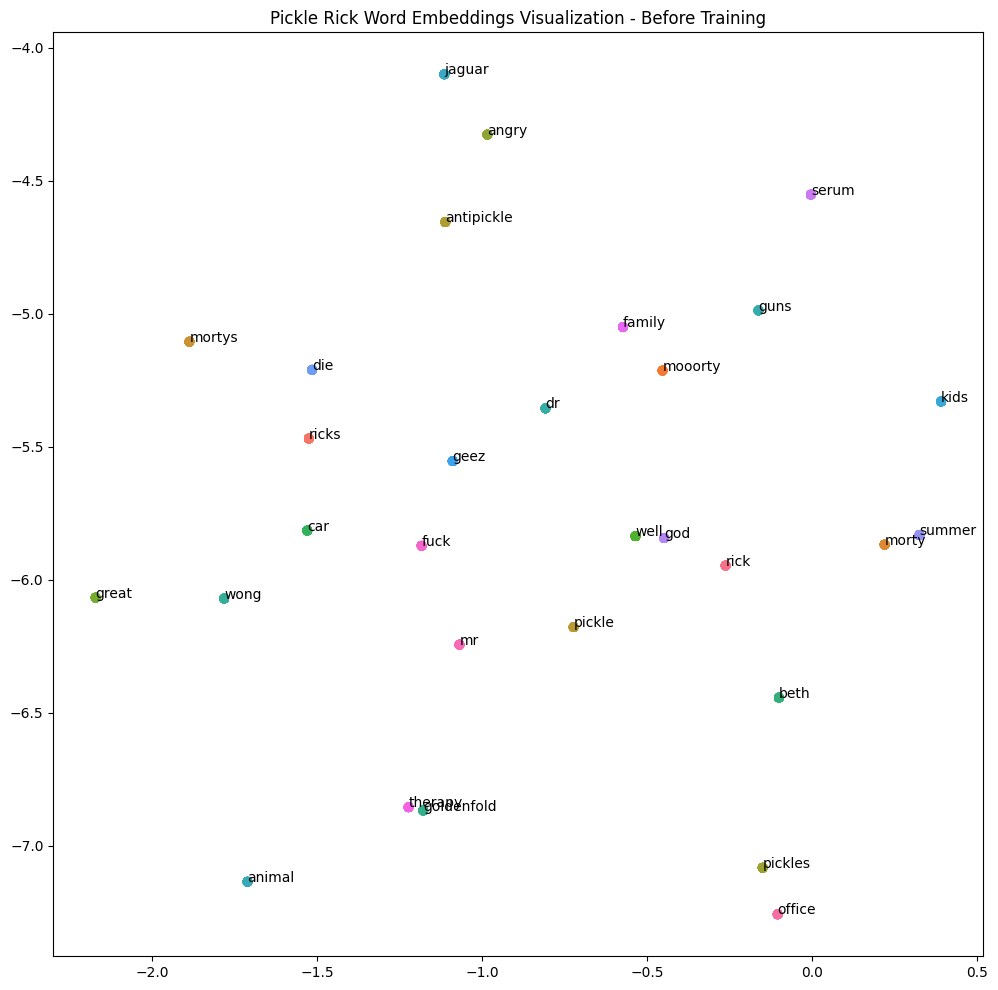

In [ ]:
# init the model instance
model = Skip_Gram_Model(len(vocabulary), embedding_size=embedding_size)

# init the loss and optimizer functions
loss_function = nn.CrossEntropyLoss() # calculates the error rate between the predicted value and the original value
optimizer = optim.Adam(model.parameters(), lr=learning_rate) # a stochastic gradient descent

# visualize the word embeddings before training
visualize_words_embedding(model,"Before Training",word2index)

# start the training process
for epoch in range(epochs):

    total_loss = 0 # restart loss to 0

    # iterate over batch size
    for i in range(0,len(X_train),batch_size):
        x = X_train[i:i+batch_size]
        y_true = y_train[i:i+batch_size]
        optimizer.zero_grad() # clear the gradients
        y_pred = model(x) # backpropagation in order to compute the gradients
        loss = loss_function(y_pred, y_true.view(-1))
        loss.backward()
        optimizer.step() # update model parameters
        total_loss += loss.item()

    print(f'Epoch num: {epoch+1}, loss value: {total_loss:.3f}')

    visualize_words_embedding(model,epoch,word2index)

In [ ]:
!zip -r /content/sample_data.zip /content/sample_data/pickle_rick_images

  adding: content/sample_data/pickle_rick_images/ (stored 0%)
  adding: content/sample_data/pickle_rick_images/word_embeddings_epoch_36.png (deflated 24%)
  adding: content/sample_data/pickle_rick_images/word_embeddings_epoch_14.png (deflated 24%)
  adding: content/sample_data/pickle_rick_images/word_embeddings_epoch_25.png (deflated 23%)
  adding: content/sample_data/pickle_rick_images/word_embeddings_epoch_32.png (deflated 23%)
  adding: content/sample_data/pickle_rick_images/word_embeddings_epoch_9.png (deflated 24%)
  adding: content/sample_data/pickle_rick_images/word_embeddings_epoch_29.png (deflated 24%)
  adding: content/sample_data/pickle_rick_images/word_embeddings_epoch_7.png (deflated 24%)
  adding: content/sample_data/pickle_rick_images/word_embeddings_epoch_12.png (deflated 24%)
  adding: content/sample_data/pickle_rick_images/word_embeddings_epoch_31.png (deflated 24%)
  adding: content/sample_data/pickle_rick_images/word_embeddings_epoch_24.png (deflated 23%)
  adding: 